In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from scipy.ndimage.filters import convolve

import dnnlib
from dnnlib import EasyDict
import dnnlib.tflib as tflib

from networks_progan import *

## Load model

In [2]:
model_dir = './pretrained_models/'
model_name = 'clevr_simple_bl'
model_filename = model_dir + model_name + '.pkl'

In [123]:
tflib.init_tf()
with open(model_filename, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

In [124]:
# Clone models and show architecture
Gs_model = Gs.clone()
Gs_model.print_layers()


Gs                Params    OutputShape         WeightShape     
---               ---       ---                 ---             
latents_in        -         (?, 12)             -               
labels_in         -         (?, 0)              -               
lod               -         ()                  -               
4x4/PixelNorm     -         (?, 12)             -               
4x4/Dense         98816     (?, 512, 4, 4)      (12, 8192)      
4x4/Conv          2359808   (?, 512, 4, 4)      (3, 3, 512, 512)
ToRGB_lod5        1539      (?, 3, 4, 4)        (1, 1, 512, 3)  
8x8/Conv0_up      2359808   (?, 512, 8, 8)      (3, 3, 512, 512)
8x8/Conv1         2359808   (?, 512, 8, 8)      (3, 3, 512, 512)
ToRGB_lod4        1539      (?, 3, 8, 8)        (1, 1, 512, 3)  
Upscale2D         -         (?, 3, 8, 8)        -               
Grow_lod4         -         (?, 3, 8, 8)        -               
16x16/Conv0_up    2359808   (?, 512, 16, 16)    (3, 3, 512, 512)
16x16/Conv1       235980

In [62]:
for var_key in list(Gs_model.vars.keys()):
    print(var_key, Gs_model.vars[var_key])

lod <tf.Variable 'Gs_1/lod:0' shape=() dtype=float32_ref>
4x4/Dense/weight <tf.Variable 'Gs_1/4x4/Dense/weight:0' shape=(12, 8192) dtype=float32_ref>
4x4/Dense/bias <tf.Variable 'Gs_1/4x4/Dense/bias:0' shape=(512,) dtype=float32_ref>
4x4/Conv/weight <tf.Variable 'Gs_1/4x4/Conv/weight:0' shape=(3, 3, 512, 512) dtype=float32_ref>
4x4/Conv/bias <tf.Variable 'Gs_1/4x4/Conv/bias:0' shape=(512,) dtype=float32_ref>
ToRGB_lod5/weight <tf.Variable 'Gs_1/ToRGB_lod5/weight:0' shape=(1, 1, 512, 3) dtype=float32_ref>
ToRGB_lod5/bias <tf.Variable 'Gs_1/ToRGB_lod5/bias:0' shape=(3,) dtype=float32_ref>
8x8/Conv0_up/weight <tf.Variable 'Gs_1/8x8/Conv0_up/weight:0' shape=(3, 3, 512, 512) dtype=float32_ref>
8x8/Conv0_up/bias <tf.Variable 'Gs_1/8x8/Conv0_up/bias:0' shape=(512,) dtype=float32_ref>
8x8/Conv1/weight <tf.Variable 'Gs_1/8x8/Conv1/weight:0' shape=(3, 3, 512, 512) dtype=float32_ref>
8x8/Conv1/bias <tf.Variable 'Gs_1/8x8/Conv1/bias:0' shape=(512,) dtype=float32_ref>
ToRGB_lod4/weight <tf.Variable

#### Sample image

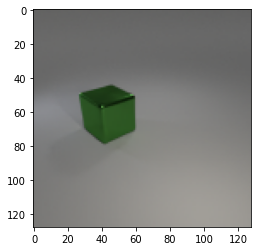

In [216]:
rnd = np.random.RandomState(1)
latents = rnd.randn(1, Gs_model.input_shape[1]).astype('float32')
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs_model.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
plt.imshow(images[0])

## Display activation maps

#### 4x4 images

Tensor("LeakyRelu_26/Maximum:0", shape=(1, 512, 4, 4), dtype=float32)


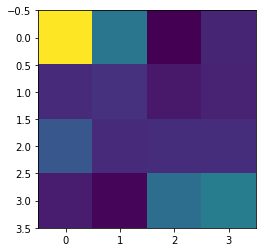

In [217]:
# 4x4 block: dense layer
x = pixel_norm(latents)
w = Gs_model.get_var('4x4/Dense/weight')
b = Gs_model.get_var('4x4/Dense/bias')[0]
x = tf.matmul(x, w) + b
x = tf.reshape(x, [1, 512, 4, 4])
x = leaky_relu(pixel_norm(x))
print(x)
plt.imshow(x.eval()[0,0])

Tensor("PixelNorm_46/mul:0", shape=(1, 512, 4, 4), dtype=float32)


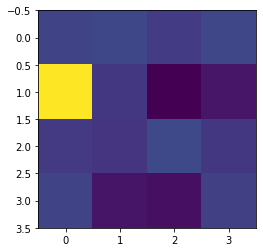

In [218]:
# 4x4 block: conv2d layer
w = Gs_model.get_var('4x4/Conv/weight')
b = Gs_model.get_var('4x4/Conv/bias')[0]
x1 = pixel_norm(leaky_relu(tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x1)
plt.imshow(x1.eval()[0,0])

Tensor("add_138:0", shape=(1, 3, 4, 4), dtype=float32)


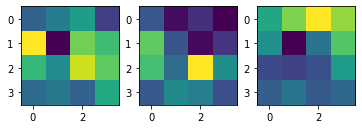

In [219]:
# 4x4 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod5/weight')
b = Gs_model.get_var('ToRGB_lod5/bias')[0]
rgb1 = tf.nn.conv2d(x1, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb1)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb1.eval()[0,c])

#### 8x8 images

Tensor("PixelNorm_47/mul:0", shape=(1, 512, 8, 8), dtype=float32)


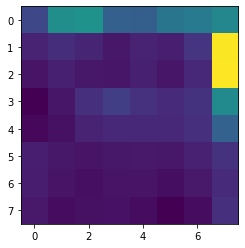

In [220]:
# 8x8 block: conv2d_transpose layer
w = Gs_model.get_var('8x8/Conv0_up/weight')
w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
os = [1, 512, 8, 8]
b = Gs_model.get_var('8x8/Conv0_up/bias')[0]
x2 = pixel_norm(leaky_relu(tf.nn.conv2d_transpose(x1, w, os, strides=[1,1,2,2], padding='SAME', data_format='NCHW') + b))
print(x2)
plt.imshow(x2.eval()[0,0])

Tensor("PixelNorm_48/mul:0", shape=(1, 512, 8, 8), dtype=float32)


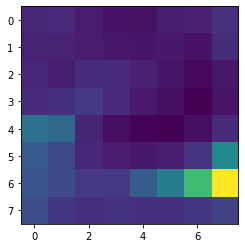

In [221]:
# 8x8 block: conv2d layer
w = Gs_model.get_var('8x8/Conv1/weight')
b = Gs_model.get_var('8x8/Conv1/bias')[0]
x3 = pixel_norm(leaky_relu(tf.nn.conv2d(x2, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x3)
plt.imshow(x3.eval()[0,0])

Tensor("add_141:0", shape=(1, 3, 8, 8), dtype=float32)


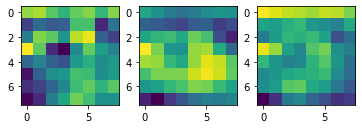

In [222]:
# 8x8 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod4/weight')
b = Gs_model.get_var('ToRGB_lod4/bias')[0]
rgb2 = tf.nn.conv2d(x3, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb2)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb2.eval()[0,c])

#### 16x16 images

Tensor("PixelNorm_49/mul:0", shape=(1, 512, 16, 16), dtype=float32)


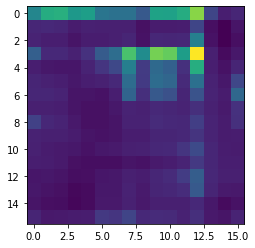

In [223]:
# 16x16 block: conv2d_transpose layer
w = Gs_model.get_var('16x16/Conv0_up/weight')
w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
os = [1, 512, 16, 16]
b = Gs_model.get_var('16x16/Conv0_up/bias')[0]
x4 = pixel_norm(leaky_relu(tf.nn.conv2d_transpose(x3, w, os, strides=[1,1,2,2], padding='SAME', data_format='NCHW') + b))
print(x4)
plt.imshow(x4.eval()[0,0])

Tensor("PixelNorm_50/mul:0", shape=(1, 512, 16, 16), dtype=float32)


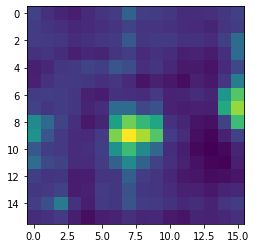

In [224]:
# 16x16 block: conv2d layer
w = Gs_model.get_var('16x16/Conv1/weight')
b = Gs_model.get_var('16x16/Conv1/bias')[0]
x5 = pixel_norm(leaky_relu(tf.nn.conv2d(x4, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x5)
plt.imshow(x5.eval()[0,0])

Tensor("add_144:0", shape=(1, 3, 16, 16), dtype=float32)


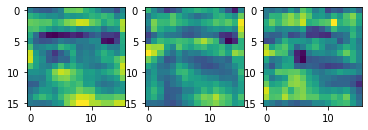

In [225]:
# 16x16 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod3/weight')
b = Gs_model.get_var('ToRGB_lod3/bias')[0]
rgb3 = tf.nn.conv2d(x5, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb3)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb3.eval()[0,c])

#### 32x32 images

Tensor("PixelNorm_51/mul:0", shape=(1, 512, 32, 32), dtype=float32)


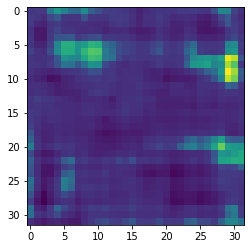

In [226]:
# 32x32 block: conv2d_transpose layer
w = Gs_model.get_var('32x32/Conv0_up/weight')
w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
os = [1, 512, 32, 32]
b = Gs_model.get_var('32x32/Conv0_up/bias')[0]
x6 = pixel_norm(leaky_relu(tf.nn.conv2d_transpose(x5, w, os, strides=[1,1,2,2], padding='SAME', data_format='NCHW') + b))
print(x6)
plt.imshow(x6.eval()[0,0])

Tensor("PixelNorm_52/mul:0", shape=(1, 512, 32, 32), dtype=float32)


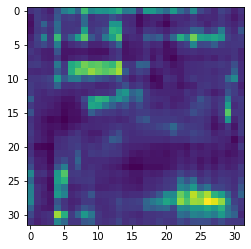

In [227]:
# 32x32 block: conv2d layer
w = Gs_model.get_var('32x32/Conv1/weight')
b = Gs_model.get_var('32x32/Conv1/bias')[0]
x7 = pixel_norm(leaky_relu(tf.nn.conv2d(x6, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x7)
plt.imshow(x7.eval()[0,0])

Tensor("add_147:0", shape=(1, 3, 32, 32), dtype=float32)


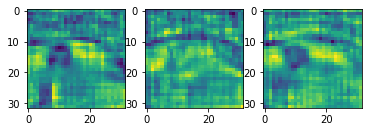

In [228]:
# 32x32 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod2/weight')
b = Gs_model.get_var('ToRGB_lod2/bias')[0]
rgb4 = tf.nn.conv2d(x7, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb4)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb4.eval()[0,c])

#### 64x64 images

Tensor("PixelNorm_53/mul:0", shape=(1, 512, 64, 64), dtype=float32)


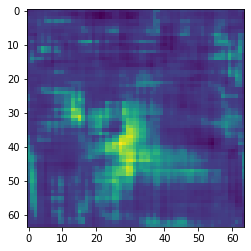

In [229]:
# 64x64 block: conv2d_transpose layer
w = Gs_model.get_var('64x64/Conv0_up/weight')
w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
os = [1, 512, 64, 64]
b = Gs_model.get_var('64x64/Conv0_up/bias')[0]
x8 = pixel_norm(leaky_relu(tf.nn.conv2d_transpose(x7, w, os, strides=[1,1,2,2], padding='SAME', data_format='NCHW') + b))
print(x8)
plt.imshow(x8.eval()[0,0])

Tensor("PixelNorm_54/mul:0", shape=(1, 256, 64, 64), dtype=float32)


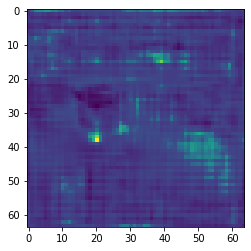

In [230]:
# 64x64 block: conv2d layer
w = Gs_model.get_var('64x64/Conv1/weight')
b = Gs_model.get_var('64x64/Conv1/bias')[0]
x9 = pixel_norm(leaky_relu(tf.nn.conv2d(x8, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x9)
plt.imshow(x9.eval()[0,0])

Tensor("add_150:0", shape=(1, 3, 64, 64), dtype=float32)


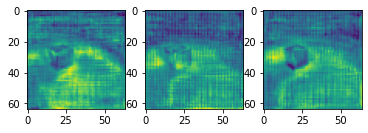

In [231]:
# 64x64 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod1/weight')
b = Gs_model.get_var('ToRGB_lod1/bias')[0]
rgb5 = tf.nn.conv2d(x9, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb5)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb5.eval()[0,c])

#### 128x128 images

Tensor("PixelNorm_55/mul:0", shape=(1, 512, 128, 128), dtype=float32)


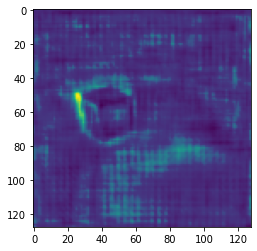

In [232]:
# 128x128 block: conv2d_transpose layer
w = Gs_model.get_var('128x128/Conv0_up/weight')
w = tf.transpose(w, [0, 1, 3, 2]) # [kernel, kernel, fmaps_out, fmaps_in]
w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
os = [1, 512, 128, 128]
b = Gs_model.get_var('128x128/Conv0_up/bias')[0]
x10 = pixel_norm(leaky_relu(tf.nn.conv2d_transpose(x9, w, os, strides=[1,1,2,2], padding='SAME', data_format='NCHW') + b))
print(x10)
plt.imshow(x10.eval()[0,0])

Tensor("PixelNorm_56/mul:0", shape=(1, 128, 128, 128), dtype=float32)


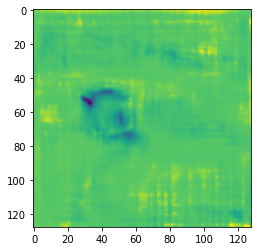

In [233]:
# 128x128 block: conv2d layer
w = Gs_model.get_var('128x128/Conv1/weight')
b = Gs_model.get_var('128x128/Conv1/bias')[0]
x11 = pixel_norm(leaky_relu(tf.nn.conv2d(x10, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b))
print(x11)
plt.imshow(x11.eval()[0,0])

Tensor("add_153:0", shape=(1, 3, 128, 128), dtype=float32)


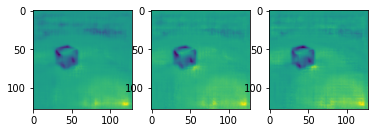

In [234]:
# 128x128 block: toRGB layer
w = Gs_model.get_var('ToRGB_lod0/weight')
b = Gs_model.get_var('ToRGB_lod0/bias')[0]
rgb6 = tf.nn.conv2d(x11, w, strides=[1,1,1,1], padding='SAME', data_format='NCHW') + b
print(rgb6)
fig, axs = plt.subplots(1, 3)
for c in range(3):
    axs[c].imshow(rgb6.eval()[0,c])